# Grid search over `L_PC_PC` and `W_E_PC_PC`

Running smln...
Smln complete.


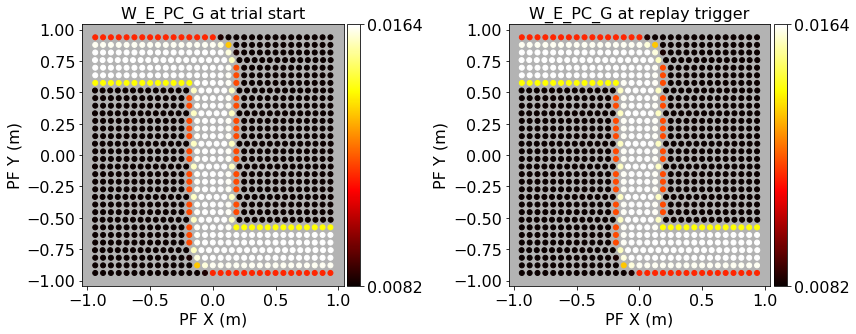

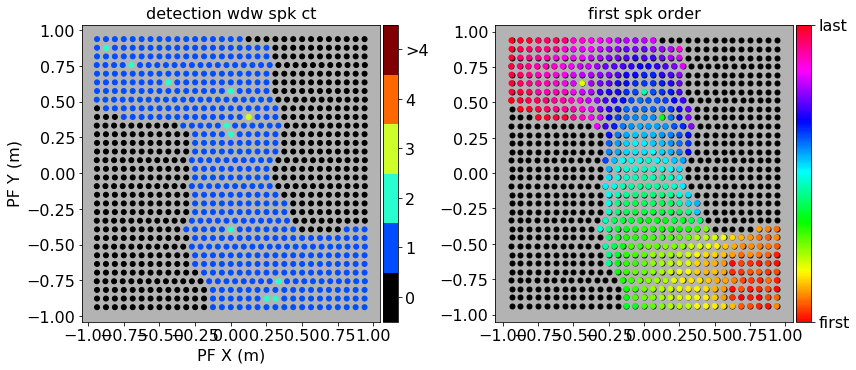

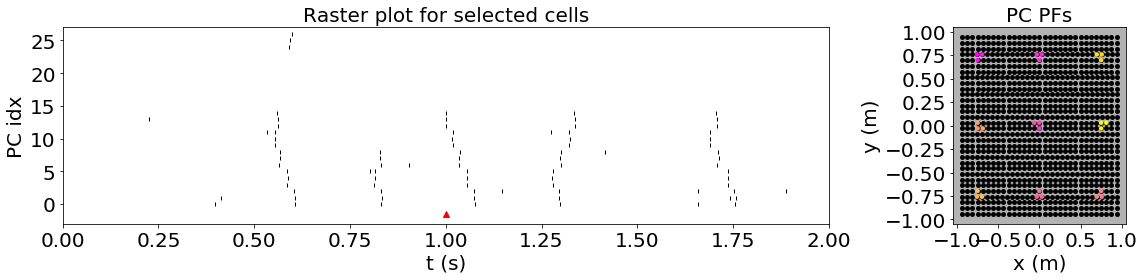

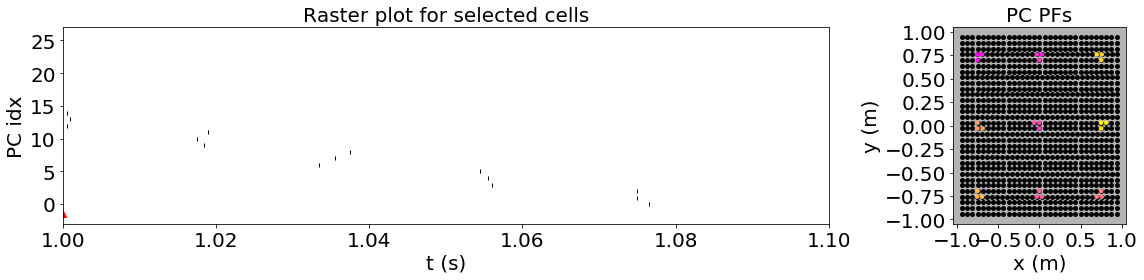

In [1]:
%reset -f
%matplotlib inline
from copy import deepcopy
from itertools import product as cprod
import sys

import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size
from replay import plot, smln


P_BASE = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    
    # Exc. PC architecture
    'N_PC': 1000,
    'W_PC_PC': 0.03, 'L_PC_PC': 0.084, 'W_MIN_PC_PC': 0.001,
    
    # "Place-tuned" PC inputs
    'W_PC_PL': 0.02, 'S_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.009, 'E_L_INH': -0.058, 'V_TH_INH': -0.036, 'V_R_INH': -0.058, 'T_R_INH': 0.002,  # unused (presently)
    
    # Inh. architecture
    'N_INH': 100,
    
    # gating inputs
    'W_PC_G': 0.008216, 'S_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.005, 
    
    # Gating input firing rates for traj and replay epochs
    'R_G': 127, 
    
    # trigger 
    'A_TRG': 0.008, 'R_TRG': 0.4, 'D_TRG': 0.003,
    
    # potentiation
    'SGM_MAX': 2,
}

S_PARAMS_BASE = {
    "RNG_SEED": 1,
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "X_TRG": 1, "Y_TRG": -0.75,
    
    #'SPD': 0.2, 'TRJ': [(-1, .75), (.75, .75), (-.75, -.75), (.75, -.75)],
    #'SPD': 0.2, 'TRJ': [(-1, .75), (.75, .75), (.75, -.75)],
    'SPD': 0.2, 'TRJ': [(-1, .75), (0, .75), (0, -.75), (1, -.75)], 
    
    "schedule": {"D_SMLN": 2, "T_TRG": 1},
    
    "metrics": {
        "WDW": 0.1, "PITCH": 10, "RADIUS": 0.2, "MIN_SCALE_TRJ": 1.25,
        "MIN_FRAC_SPK_TRJ": 0.75, "MAX_AVG_SPK_CT_TRJ": 3, "TRJ_NON_TRJ_SPK_RATIO": 1.5,
    }}

print('Running smln...')
rslt = smln.run(P_BASE, S_PARAMS_BASE)
print('Smln complete.')

# make plots
plot.heat_maps(rslt, (1, 1.15));

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    (-.75, 0), (-.75, -.75), (.75, .75), (.75, 0),  # non-trj
    ],
    nearest=3,
    epoch='replay');

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    (-.75, 0), (-.75, -.75), (.75, .75), (.75, 0),  # non-trj
    ],
    nearest=3,
    epoch=(1, 1.1));

In [2]:
L_PC_PCS = np.linspace(0.06, 0.15, 91)
W_PC_PCS = np.linspace(0.005, 0.04, 36)
N_TRIALS = 8

np.random.seed(0)

ctr = 0
total = len(list(cprod(L_PC_PCS, W_PC_PCS)))
success_sums = []

for l_pc_pc, w_pc_pc in cprod(L_PC_PCS, W_PC_PCS):
    
    if ctr % 100 == 0:
        print('Trial {}'.format(ctr+1))
        
    sys.stdout.write('.')
    
    # set up smln params
    p = deepcopy(P_BASE)
    p['L_PC_PC'] = l_pc_pc
    p['W_PC_PC'] = w_pc_pc
    
    s_params = deepcopy(S_PARAMS_BASE)
    
    rng_seeds = []
    successes = []
    
    # loop over rng seeds
    for tr_ctr in range(N_TRIALS):
        
        rng_seed = np.random.randint(0, 2**32)
        
        s_params['RNG_SEED'] = rng_seed
        
        rslt = smln.run(p, s_params)
        
        rng_seeds.append(rng_seed)
        successes.append(rslt.success)
        
    # save results
    line = '{}/{}, {}/{}, {}, {}\n'.format(ctr, total, np.sum(successes), N_TRIALS, rng_seeds, p)
    
    with open('temp_2B.1.dat', 'a') as f:
        f.write(line)
        
    success_sums.append(np.sum(successes))
        
    ctr += 1

Trial 1
....................................................................................................Trial 101
....................................................................................................Trial 201
....................................................................................................Trial 301
....................................................................................................Trial 401
....................................................................................................Trial 501
....................................................................................................Trial 601
....................................................................................................Trial 701
....................................................................................................Trial 801
....................................................................................................Trial 901
..

/home/rkp/Dropbox/Repositories/seq_speak/replay/smln.py:378: RuntimeWarning: Mean of empty slice.
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


..................................................................Trial 3001
....................................................................................................Trial 3101
....................................................................................................Trial 3201
............................................................................

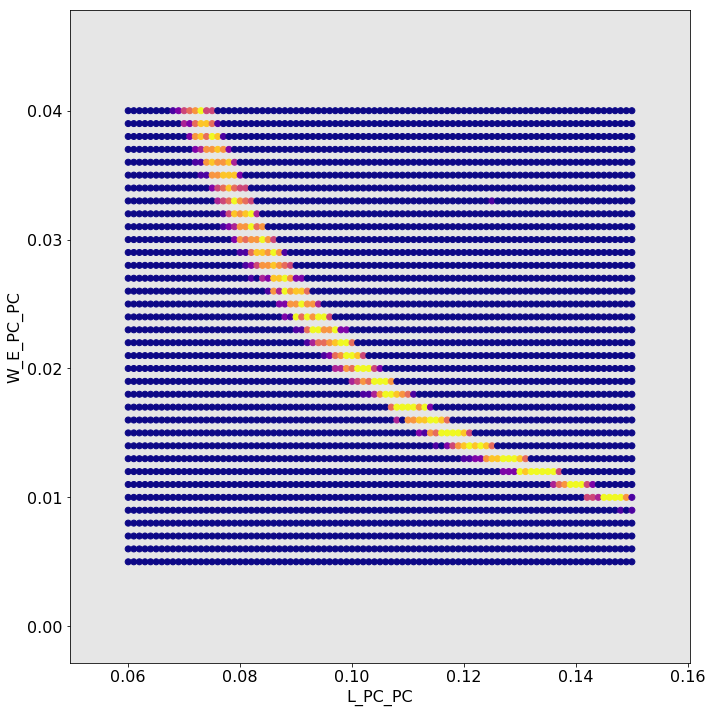

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), tight_layout=True)

l_pc_pcs, w_pc_pcs = np.transpose(list(cprod(L_PC_PCS, W_PC_PCS)))

ax.scatter(l_pc_pcs, w_pc_pcs, c=success_sums, vmin=0, vmax=8, cmap='plasma')

ax.set_xlabel('L_PC_PC')
ax.set_ylabel('W_PC_PC')
ax.set_facecolor((.9, .9, .9))

set_font_size(ax, 16)

# Grid search 1 over `W_G_MAX` and `FR_RPL_PC_G`

Running smln...
Smln complete.


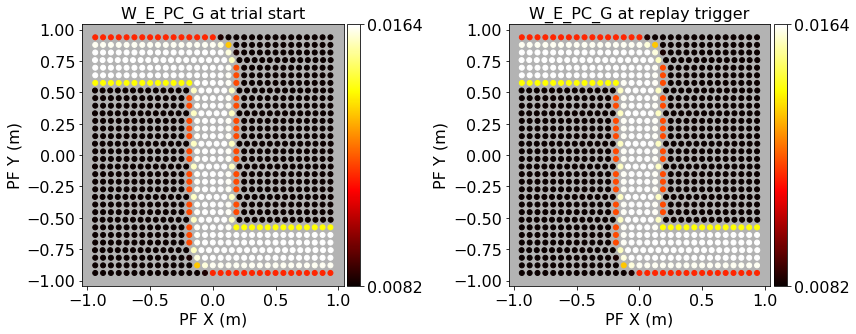

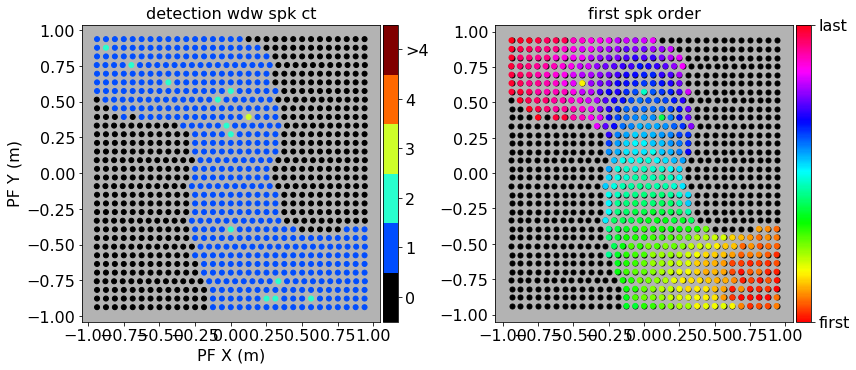

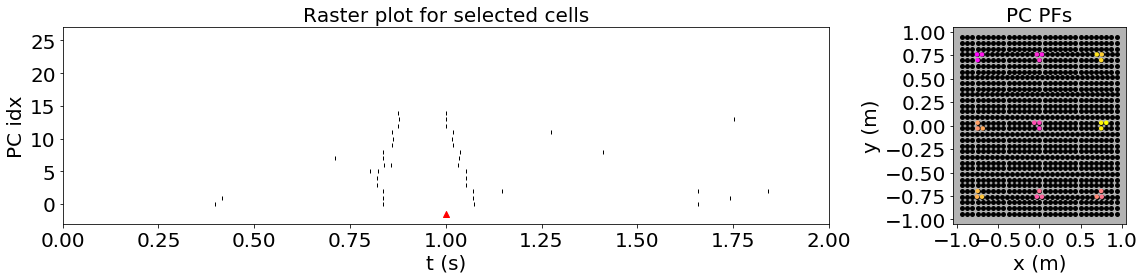

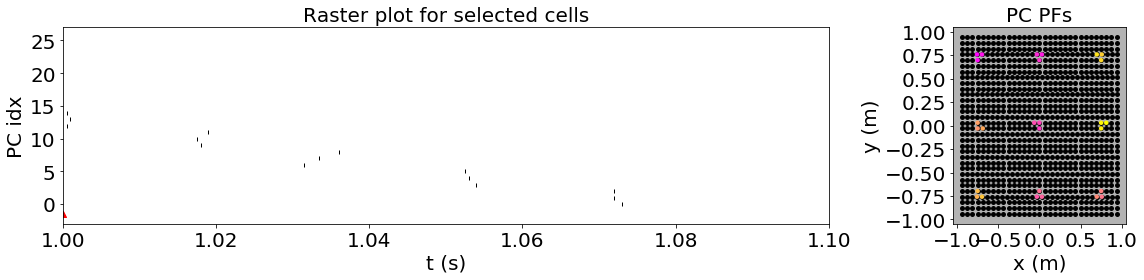

In [1]:
%reset -f
%matplotlib inline
from copy import deepcopy
from itertools import product as cprod
import sys

import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size
from replay import plot, smln


P_BASE = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    
    # Exc. PC architecture
    'N_PC': 1000,
    'W_PC_PC': 0.017, 'L_PC_PC': 0.11, 'W_MIN_PC_PC': 0.001,
    
    # "Place-tuned" PC inputs
    'W_PC_PL': 0.02, 'S_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.009, 'E_L_INH': -0.058, 'V_TH_INH': -0.036, 'V_R_INH': -0.058, 'T_R_INH': 0.002,  # unused (presently)
    
    # Inh. architecture
    'N_INH': 100,
    
    # gating inputs
    'W_PC_G': 0.008216, 'S_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.005, 
    
    # Gating input firing rates for traj and replay epochs
    'R_G': 127, 
    
    # trigger 
    'A_TRG': 0.008, 'R_TRG': 0.4, 'D_TRG': 0.003,
    
    # potentiation
    'SGM_MAX': 2,
}

S_PARAMS_BASE = {
    "RNG_SEED": 1,
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "X_TRG": 1, "Y_TRG": -0.75,
    
    #'SPD': 0.2, 'TRJ': [(-1, .75), (.75, .75), (-.75, -.75), (.75, -.75)],
    #'SPD': 0.2, 'TRJ': [(-1, .75), (.75, .75), (.75, -.75)],
    'SPD': 0.2, 'TRJ': [(-1, .75), (0, .75), (0, -.75), (1, -.75)], 
    
    "schedule": {"D_SMLN": 2, "T_TRG": 1},
    
    "metrics": {
        "WDW": 0.1, "PITCH": 10, "RADIUS": 0.2, "MIN_SCALE_TRJ": 1.25,
        "MIN_FRAC_SPK_TRJ": 0.75, "MAX_AVG_SPK_CT_TRJ": 3, "TRJ_NON_TRJ_SPK_RATIO": 1.5,
    }}

print('Running smln...')
rslt = smln.run(P_BASE, S_PARAMS_BASE)
print('Smln complete.')

# make plots
plot.heat_maps(rslt, (1, 1.15));

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    (-.75, 0), (-.75, -.75), (.75, .75), (.75, 0),  # non-trj
    ],
    nearest=3,
    epoch='replay');

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    (-.75, 0), (-.75, -.75), (.75, .75), (.75, 0),  # non-trj
    ],
    nearest=3,
    epoch=(1, 1.1));

In [2]:
SGM_MAXS = np.linspace(1, 3, 41)
R_GS = np.linspace(80, 160, 41)
N_TRIALS = 8

np.random.seed(0)

ctr = 0
total = len(list(cprod(SGM_MAXS, R_GS)))
success_sums = []

for sgm_max, r_g in cprod(SGM_MAXS, R_GS):
    
    if ctr % 100 == 0:
        print('Trial {}'.format(ctr+1))
        
    sys.stdout.write('.')
    
    # set up smln params
    p = deepcopy(P_BASE)
    p['SGM_MAX'] = sgm_max
    p['R_G'] = r_g
    
    s_params = deepcopy(S_PARAMS_BASE)
    
    rng_seeds = []
    successes = []
    
    # loop over rng seeds
    for tr_ctr in range(N_TRIALS):
        
        rng_seed = np.random.randint(0, 2**32)
        
        s_params['RNG_SEED'] = rng_seed
        
        rslt = smln.run(p, s_params)
        
        rng_seeds.append(rng_seed)
        successes.append(rslt.success)
        
    # save results
    line = '{}/{}, {}/{}, {}, {}\n'.format(ctr, total, np.sum(successes), N_TRIALS, rng_seeds, p)
    
    with open('temp_2B.dat', 'a') as f:
        f.write(line)
        
    success_sums.append(np.sum(successes))
        
    ctr += 1

Trial 1
.

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rkp/Dropbox/Repositories/seq_speak/replay/smln.py:378: RuntimeWarning: Mean of empty slice.
  avg_spk_ct_trj = spks_trj.sum(0)[spks_trj.sum(0) > 0].mean()


...................................................................................................Trial 101
....................................................................................................Trial 201
....................................................................................................Trial 301
....................................................................................................Trial 401
....................................................................................................Trial 501
....................................................................................................Trial 601
....................................................................................................Trial 701
....................................................................................................Trial 801
....................................................................................................Trial 901
...........

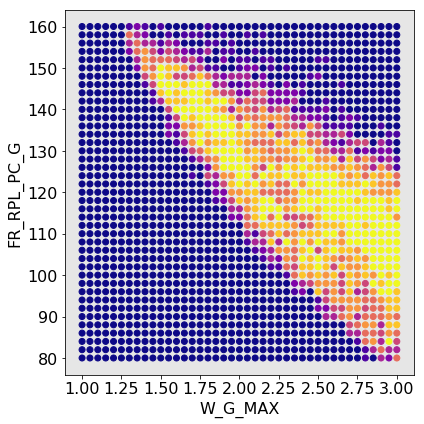

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)

sgm_max, r_g = np.transpose(list(cprod(SGM_MAXS, R_GS)))

ax.scatter(sgm_max, r_g, c=success_sums, vmin=0, vmax=8, cmap='plasma')

ax.set_xlabel('$\sigma_{max}$')
ax.set_ylabel('R_G')
ax.set_facecolor((.9, .9, .9))

set_font_size(ax, 16)

# Grid search 2 over `W_G_MAX` and `FR_RPL_PC_G`

In [ ]:
%reset -f
%matplotlib inline
from copy import deepcopy
from itertools import product as cprod
import sys

import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size
from replay import plot, smln


P_BASE = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    
    # Exc. PC architecture
    'N_PC': 1000,
    'W_PC_PC': 0.03, 'L_PC_PC': 0.084, 'W_MIN_PC_PC': 0.001,
    
    # "Place-tuned" PC inputs
    'W_PC_PL': 0.02, 'S_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.009, 'E_L_INH': -0.058, 'V_TH_INH': -0.036, 'V_R_INH': -0.058, 'T_R_INH': 0.002,  # unused (presently)
    
    # Inh. architecture
    'N_INH': 100,
    
    # gating inputs
    'W_PC_G': 0.008216, 'S_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.005, 
    
    # Gating input firing rates for traj and replay epochs
    'R_G': 127, 
    
    # trigger 
    'A_TRG': 0.008, 'R_TRG': 0.4, 'D_TRG': 0.003,
    
    # potentiation
    'SGM_MAX': 2,
}

S_PARAMS_BASE = {
    "RNG_SEED": 1,
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "X_TRG": 1, "Y_TRG": -0.75,
    
    #'SPD': 0.2, 'TRJ': [(-1, .75), (.75, .75), (-.75, -.75), (.75, -.75)],
    #'SPD': 0.2, 'TRJ': [(-1, .75), (.75, .75), (.75, -.75)],
    'SPD': 0.2, 'TRJ': [(-1, .75), (0, .75), (0, -.75), (1, -.75)], 
    
    "schedule": {"D_SMLN": 2, "T_TRG": 1},
    
    "metrics": {
        "WDW": 0.1, "PITCH": 10, "RADIUS": 0.2, "MIN_SCALE_TRJ": 1.25,
        "MIN_FRAC_SPK_TRJ": 0.75, "MAX_AVG_SPK_CT_TRJ": 3, "TRJ_NON_TRJ_SPK_RATIO": 1.5,
    }}

print('Running smln...')
rslt = smln.run(P_BASE, S_PARAMS_BASE)
print('Smln complete.')

# make plots
plot.heat_maps(rslt, (1, 1.15));

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    (-.75, 0), (-.75, -.75), (.75, .75), (.75, 0),  # non-trj
    ],
    nearest=3,
    epoch='replay');

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    (-.75, 0), (-.75, -.75), (.75, .75), (.75, 0),  # non-trj
    ],
    nearest=3,
    epoch=(1, 1.1));

In [ ]:
SGM_MAXS = np.linspace(1, 3, 41)
R_GS = np.linspace(80, 160, 41)
N_TRIALS = 8

np.random.seed(0)

ctr = 0
total = len(list(cprod(SGM_MAXS, R_GS)))
success_sums = []

for sgm_max, r_g in cprod(SGM_MAXS, R_GS):
    
    if ctr % 100 == 0:
        print('Trial {}'.format(ctr+1))
        
    sys.stdout.write('.')
    
    # set up smln params
    p = deepcopy(P_BASE)
    p['SGM_MAX'] = sgm_max
    p['R_G'] = r_g
    
    s_params = deepcopy(S_PARAMS_BASE)
    
    rng_seeds = []
    successes = []
    
    # loop over rng seeds
    for tr_ctr in range(N_TRIALS):
        
        rng_seed = np.random.randint(0, 2**32)
        
        s_params['RNG_SEED'] = rng_seed
        
        rslt = smln.run(p, s_params)
        
        rng_seeds.append(rng_seed)
        successes.append(rslt.success)
        
    # save results
    line = '{}/{}, {}/{}, {}, {}\n'.format(ctr, total, np.sum(successes), N_TRIALS, rng_seeds, p)
    
    with open('temp_2B.1.dat', 'a') as f:
        f.write(line)
        
    success_sums.append(np.sum(successes))
        
    ctr += 1

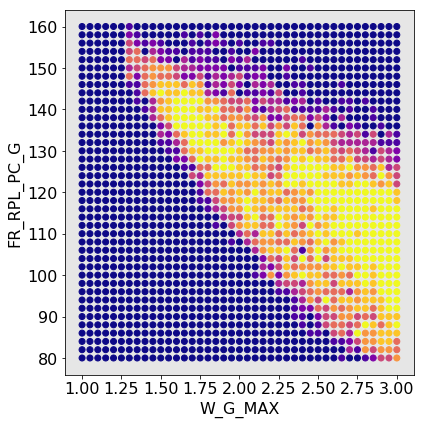

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)

sgm_max, r_g = np.transpose(list(cprod(SGM_MAXS, R_GS)))

ax.scatter(w_g_max, fr_rpl_pc_g, c=success_sums, vmin=0, vmax=8, cmap='plasma')

ax.set_xlabel('\sigma_{max}')
ax.set_ylabel('R_G')
ax.set_facecolor((.9, .9, .9))

set_font_size(ax, 16)

# Grid search 3 over `W_G_MAX` and `FR_RPL_PC_G`

In [ ]:
%reset -f
%matplotlib inline
from copy import deepcopy
from itertools import product as cprod
import sys

import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size
from replay import plot, smln


P_BASE = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    
    # Exc. PC architecture
    'N_PC': 1000,
    'W_PC_PC': 0.017, 'L_PC_PC': 0.11, 'W_MIN_PC_PC': 0.001,
    
    # "Place-tuned" PC inputs
    'W_PC_PL': 0.02, 'S_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.009, 'E_L_INH': -0.058, 'V_TH_INH': -0.036, 'V_R_INH': -0.058, 'T_R_INH': 0.002,  # unused (presently)
    
    # Inh. architecture
    'N_INH': 100,
    
    # gating inputs
    'W_PC_G': 0.008216, 'S_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.005, 
    
    # Gating input firing rates for traj and replay epochs
    'R_G': 127, 
    
    # trigger 
    'A_TRG': 0.008, 'R_TRG': 0.4, 'D_TRG': 0.003,
    
    # potentiation
    'SGM_MAX': 2,
}

S_PARAMS_BASE = {
    "RNG_SEED": 1,
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "X_TRG": 1, "Y_TRG": -0.75,
    
    #'SPD': 0.2, 'TRJ': [(-1, .75), (.75, .75), (-.75, -.75), (.75, -.75)],
    #'SPD': 0.2, 'TRJ': [(-1, .75), (.75, .75), (.75, -.75)],
    'SPD': 0.2, 'TRJ': [(-1, .75), (0, .75), (0, -.75), (1, -.75)], 
    
    "schedule": {"D_SMLN": 2, "T_TRG": 1},
    
    "metrics": {
        "WDW": 0.1, "PITCH": 10, "RADIUS": 0.2, "MIN_SCALE_TRJ": 1.25,
        "MIN_FRAC_SPK_TRJ": 0.75, "MAX_AVG_SPK_CT_TRJ": 3, "TRJ_NON_TRJ_SPK_RATIO": 1.5,
    }}

print('Running smln...')
rslt = smln.run(P_BASE, S_PARAMS_BASE)
print('Smln complete.')

# make plots
plot.heat_maps(rslt, (1, 1.15));

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    (-.75, 0), (-.75, -.75), (.75, .75), (.75, 0),  # non-trj
    ],
    nearest=3,
    epoch='replay');

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    (-.75, 0), (-.75, -.75), (.75, .75), (.75, 0),  # non-trj
    ],
    nearest=3,
    epoch=(1, 1.1));

In [ ]:
SGM_MAXS = np.linspace(1.75, 2.5, 31)
R_GS = np.linspace(110, 140, 31)
N_TRIALS = 30

np.random.seed(0)

ctr = 0
total = len(list(cprod(SGM_MAXS, R_GS)))
success_sums = []

for sgm_max, r_g in cprod(SGM_MAXS, R_GS):
    
    if ctr % 100 == 0:
        print('Trial {}'.format(ctr+1))
        
    sys.stdout.write('.')
    
    # set up smln params
    p = deepcopy(P_BASE)
    p['SGM_MAX'] = sgm_max
    p['R_G'] = r_g
    
    s_params = deepcopy(S_PARAMS_BASE)
    
    rng_seeds = []
    successes = []
    
    # loop over rng seeds
    for tr_ctr in range(N_TRIALS):
        
        rng_seed = np.random.randint(0, 2**32)
        
        s_params['RNG_SEED'] = rng_seed
        
        rslt = smln.run(p, s_params)
        
        rng_seeds.append(rng_seed)
        successes.append(rslt.success)
        
    # save results
    line = '{}/{}, {}/{}, {}, {}\n'.format(ctr, total, np.sum(successes), N_TRIALS, rng_seeds, p)
    
    with open('temp_2B.dat', 'a') as f:
        f.write(line)
        
    success_sums.append(np.sum(successes))
        
    ctr += 1

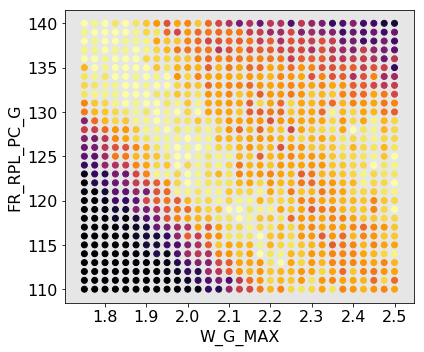

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5), tight_layout=True)

sgm_max, r_g = np.transpose(list(cprod(SGM_MAXS, R_GS)))

ax.scatter(sgm_max, r_g, c=success_sums, vmin=0, vmax=30, cmap='inferno')

ax.set_xlabel('SGM_MAX')
ax.set_ylabel('R_G')
ax.set_facecolor((.9, .9, .9))

set_font_size(ax, 16)

# Grid search 4 over `W_G_MAX` and `FR_RPL_PC_G`

In [ ]:
%reset -f
%matplotlib inline
from copy import deepcopy
from itertools import product as cprod
import sys

import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size
from replay import plot, smln


P_BASE = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    
    # Exc. PC architecture
    'N_PC': 1000,
    'W_PC_PC': 0.017, 'L_PC_PC': 0.11, 'W_MIN_PC_PC': 0.001,
    
    # "Place-tuned" PC inputs
    'W_PC_PL': 0.02, 'S_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.009, 'E_L_INH': -0.058, 'V_TH_INH': -0.036, 'V_R_INH': -0.058, 'T_R_INH': 0.002,  # unused (presently)
    
    # Inh. architecture
    'N_INH': 100,
    
    # gating inputs
    'W_PC_G': 0.008216, 'S_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.005, 
    
    # Gating input firing rates for traj and replay epochs
    'R_G': 127, 
    
    # trigger 
    'A_TRG': 0.008, 'R_TRG': 0.4, 'D_TRG': 0.003,
    
    # potentiation
    'SGM_MAX': 2,
}

S_PARAMS_BASE = {
    "RNG_SEED": 1,
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "X_TRG": 1, "Y_TRG": -0.75,
    
    #'SPD': 0.2, 'TRJ': [(-1, .75), (.75, .75), (-.75, -.75), (.75, -.75)],
    #'SPD': 0.2, 'TRJ': [(-1, .75), (.75, .75), (.75, -.75)],
    'SPD': 0.2, 'TRJ': [(-1, .75), (0, .75), (0, -.75), (1, -.75)], 
    
    "schedule": {"D_SMLN": 2, "T_TRG": 1},
    
    "metrics": {
        "WDW": 0.1, "PITCH": 10, "RADIUS": 0.2, "MIN_SCALE_TRJ": 1.25,
        "MIN_FRAC_SPK_TRJ": 0.75, "MAX_AVG_SPK_CT_TRJ": 3, "TRJ_NON_TRJ_SPK_RATIO": 1.5,
    }}

print('Running smln...')
rslt = smln.run(P_BASE, S_PARAMS_BASE)
print('Smln complete.')

# make plots
plot.heat_maps(rslt, (1, 1.15));

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    (-.75, 0), (-.75, -.75), (.75, .75), (.75, 0),  # non-trj
    ],
    nearest=3,
    epoch='replay');

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    (-.75, 0), (-.75, -.75), (.75, .75), (.75, 0),  # non-trj
    ],
    nearest=3,
    epoch=(1, 1.1));

In [ ]:
SGM_MAXS = np.linspace(.75, 1.75, 31)
R_GS = np.linspace(130, 180, 51)
N_TRIALS = 30

np.random.seed(0)

ctr = 0
total = len(list(cprod(SGM_MAXS, R_GS)))
success_sums = []

for sgm_max, r_g in cprod(SGM_MAXS, R_GS):
    
    if ctr % 100 == 0:
        print('Trial {}'.format(ctr+1))
        
    sys.stdout.write('.')
    
    # set up smln params
    p = deepcopy(P_BASE)
    p['SGM_MAX'] = sgm_max
    p['R_G'] = r_g
    
    s_params = deepcopy(S_PARAMS_BASE)
    
    rng_seeds = []
    successes = []
    
    # loop over rng seeds
    for tr_ctr in range(N_TRIALS):
        
        rng_seed = np.random.randint(0, 2**32)
        
        s_params['RNG_SEED'] = rng_seed
        
        rslt = smln.run(p, s_params)
        
        rng_seeds.append(rng_seed)
        successes.append(rslt.success)
        
    # save results
    line = '{}/{}, {}/{}, {}, {}\n'.format(ctr, total, np.sum(successes), N_TRIALS, rng_seeds, p)
    
    with open('temp_2B.1.dat', 'a') as f:
        f.write(line)
        
    success_sums.append(np.sum(successes))
        
    ctr += 1

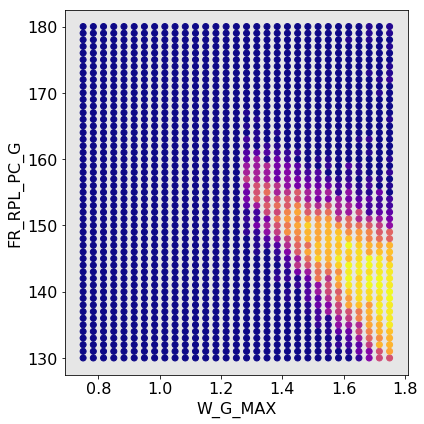

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)

sgm_max, r_g = np.transpose(list(cprod(SGM_MAXS, R_GS)))

ax.scatter(sgm_max, r_g, c=success_sums, vmin=0, vmax=30, cmap='plasma')

ax.set_xlabel('SGM_MAX')
ax.set_ylabel('R_G')
ax.set_facecolor((.9, .9, .9))

set_font_size(ax, 16)